In [30]:
import os
import rasterio as rio
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from osgeo import gdal
from progressbar import ProgressBar
from shapely.geometry import Point

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

from sklearn.model_selection import  GridSearchCV

from utils import calculate_box_grid, build_boxes

plt.rcParams["figure.figsize"] = (28,10)
plt.ion()

In [5]:
data_dir = 'data_100m'
dem_file = f'{data_dir}/dem.tif'

In [21]:
variables = [
    'dem', 
    'slope', 
    'north', 
    'east', 
#    'veg', 
    'veg_agg', 
    'urban_d', 
    'roads_d', 
    'crops_d'
]


In [6]:
with rio.open(dem_file) as src:
    print(f'Reading dem file {dem_file}')
    dem = src.read(1)
    dem[dem <= -9999] = np.NaN
_, dx, _, _, _, dy = src.transform.to_gdal()    
bbox = src.bounds

In [7]:
dataset = gpd.read_file(f'{data_dir}/dataset.geojson')
dataset.head()

## Geographic Split Train/Test

In [11]:
box_dim = 3000.0
lon_min, lon_max, lon_step, lat_min, lat_max, lat_step = calculate_box_grid(bbox, dx, dy, box_dim)

box_lons, box_lats = build_boxes(lon_min, lon_max, lon_step, lat_min, lat_max, lat_step)

boxes_geoms = [Point(x, y).buffer(box_dim/2).envelope for x, y in zip(box_lons.flatten(), box_lats.flatten())]
boxes_gdf = gpd.GeoDataFrame([], geometry=boxes_geoms, crs=dataset.crs)

In [12]:
# intersects boxes with rows
dataset_boxes = gpd.sjoin(dataset, boxes_gdf)

In [13]:
test_train_ratio = 0.3
boxes_with_points = dataset_boxes['index_right'].unique()
test_boxes = np.random.choice(boxes_with_points, int(len(boxes_with_points) * test_train_ratio))

In [14]:
# select test rows
dataset_test = dataset_boxes.query('index_right in @test_boxes')

# select train rows
dataset_train = dataset_boxes.query('index_right not in @test_boxes')

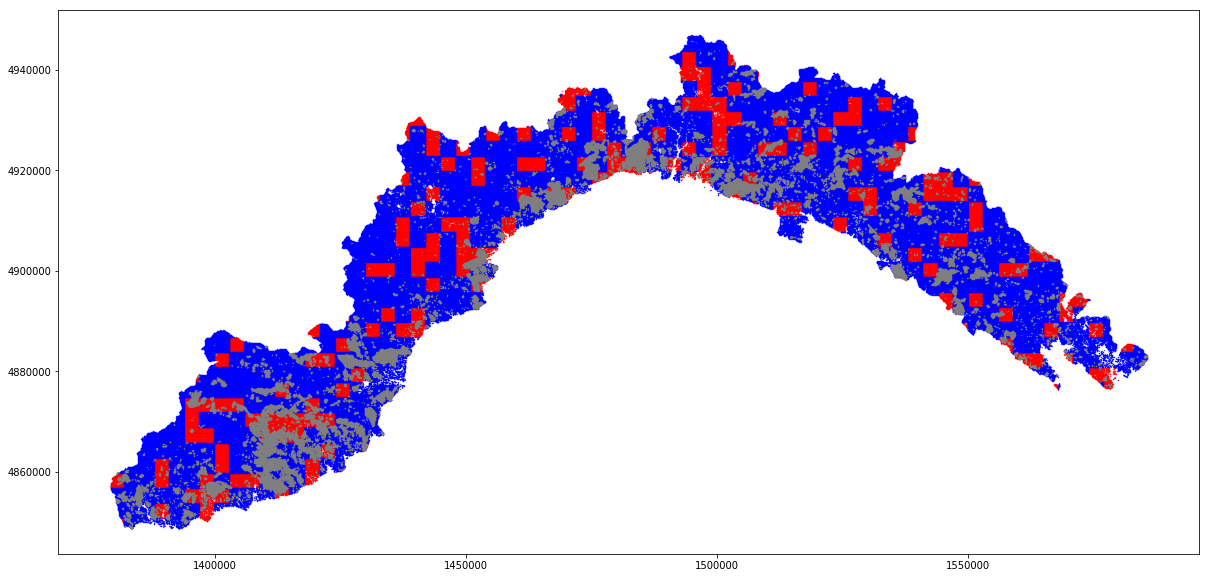

In [16]:
fig, ax = plt.subplots(1, 1)
dataset_test.plot(ax=ax, markersize=0.1, color='red')
dataset_train.plot(ax=ax, markersize=0.1, color='blue')
dataset.query('fire == 1').plot(ax=ax,  markersize=0.1, color='gray')

In [17]:
len(dataset_test.query('fire == 1 & stagione==1')), \
len(dataset_train.query('fire == 1 & stagione==1')), \
len(dataset_test.query('fire == 1 & stagione==2')), \
len(dataset_train.query('fire == 1 & stagione==2'))

(22087, 45790, 10990, 35178)

# Training on geographic subset

In [24]:
sample_size = 0.1
season = 2

In [25]:
# create a dataset selecting a sample of points from fire points, then the same amount of absence
presence_train_dataset = dataset_train.query(f'(anno < 2013) & (stagione == {season})')
presence_test_dataset = dataset_test.query(f'(anno >= 2013) & (stagione == {season})')

presence_train_sample = presence_train_dataset.query('fire == 1').sample(frac=sample_size).loc[:, variables + ['fire']]
absence_train_sample = dataset_train.query('fire == 0').sample(n=len(presence_train_sample)).loc[:, variables + ['fire']]

train_df = pd.concat((presence_train_sample, absence_train_sample))

presence_test_sample = dataset_test.query('fire == 1').loc[:, variables + ['fire']]
absence_test_sample = dataset_test.query('fire == 0').sample(n=len(presence_test_sample)).loc[:, variables + ['fire']]

test_df = pd.concat((presence_test_sample, absence_test_sample))

In [ ]:
X_train = train_df.loc[:, variables]
y_train = train_df.loc[:, 'fire']

X_test = test_df.loc[:, variables]
y_test = test_df.loc[:, 'fire']

# set seed for reproducibility
SEED = 42

#instantiate a random forest regressor 'rf'

rf = RandomForestClassifier(random_state=SEED)

# Tuning the hypermarameters of Random forest ; 
# Define the dictionary 'params_rf'(the values are examples); more parameters to be tuned are readable
# using rf.get_params() 
params_rf = {
     'n_estimators': [1000],
     'max_features': ['log2'] #[5, 6, 7, 8],
}


# Instantiate grid_rf (rf is an untuned random forest regressor model)
# note that n_jobs= -1 remove any restriction on the use of all the CPU cores
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       verbose=1,
                       n_jobs=-1)

# Fit the model 
grid_rf.fit(X_train, y_train)

In [31]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute rmse_test
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)

# Print rmse_test
print(f'Test RMSE of best model: {rmse_test:.3f}') 

Test RMSE of best model: 0.595


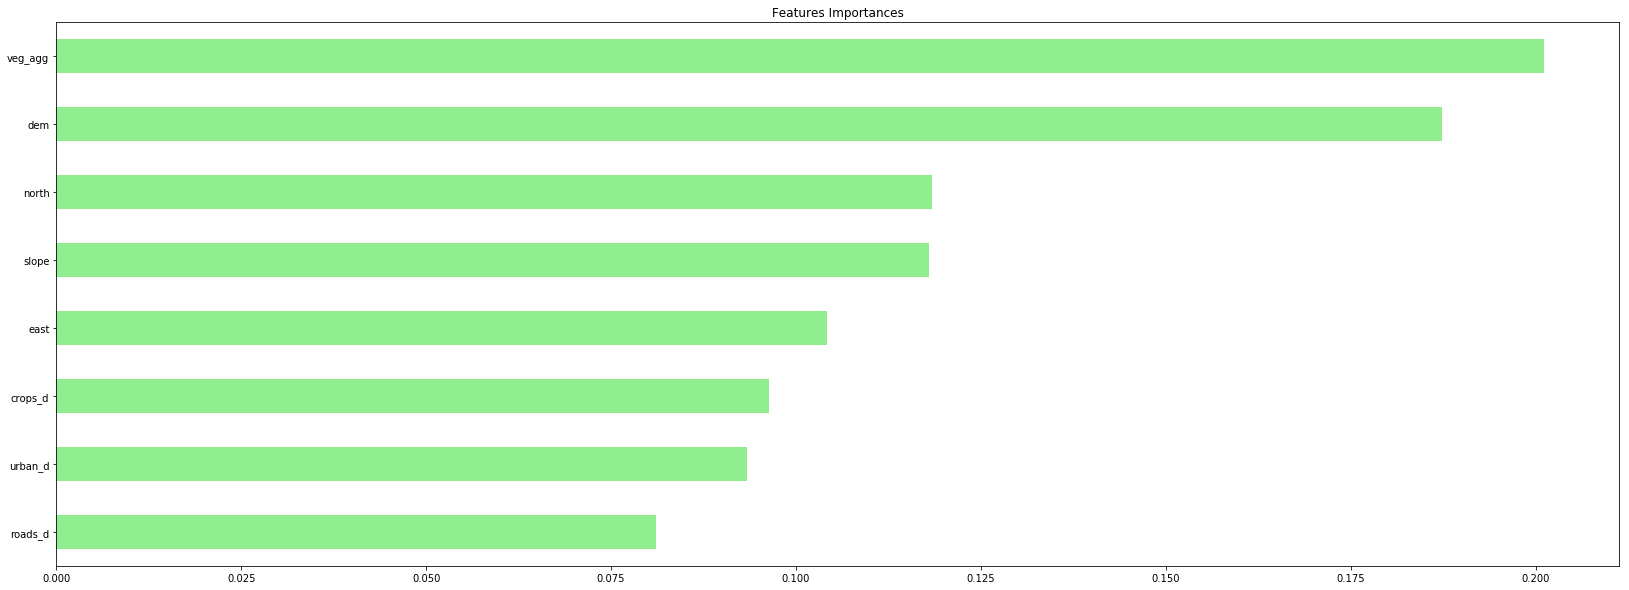

In [32]:
# Create a pd.Series of features importances
importances = pd.Series(data=best_model.feature_importances_,
                        index=variables)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [33]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))  
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {(100*accuracy):.2f}%')  

[[25471  7606]
 [15831 17246]]
              precision    recall  f1-score   support

           0       0.62      0.77      0.68     33077
           1       0.69      0.52      0.60     33077

   micro avg       0.65      0.65      0.65     66154
   macro avg       0.66      0.65      0.64     66154
weighted avg       0.66      0.65      0.64     66154

Accuracy: 64.57%


## Create Map


In [56]:
X_complete = dataset.loc[:, variables]
y_complete = best_model.predict_proba(X_complete)

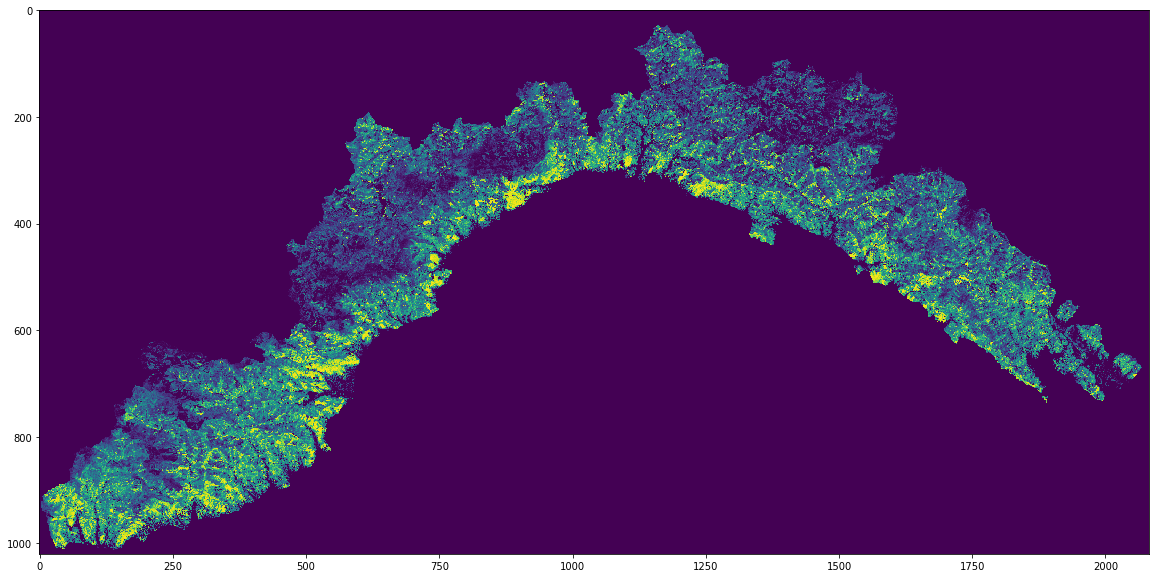

In [57]:
_map = np.empty_like(dem)
_map[dataset['row'].values, dataset['col'].values] = y_complete[:,1]
plt.imshow(_map)

In [58]:
save_raster_as(_map, f'{data_dir}/summer_map.tiff', dem_file)